In [ ]:
import networkx as nx
import pandas as pd
import community as community_louvain  
import igraph as ig
from cdlib import algorithms  

df = pd.read_csv("Project_1_coauthor_edges.csv")
# Gán tên cột
df.columns = ["Author1", "Author2", "Weight"]
# Chuyển đổi cột Weight sang kiểu số nguyên
df["Weight"] = df["Weight"].astype(str).str.extract(r"(\d+)").astype(int)
df.head()

,Author1,Author2,Weight
0,Joseph Sambrook,Tom Maniatis,1
1,Elisabeth Fritsch,Tom Maniatis,1
2,Keith E. Muller,Jacob Cohen,1
3,Jacob Cohen,Peter A. Lachenbruch,1
4,Jacob Cohen,Sylvia Wassertheil,1


In [16]:
# Tạo graph từ edge list
import networkx as nx
import igraph as ig

# NetworkX Graph
G = nx.from_pandas_edgelist(df, "Author1", "Author2", edge_attr="Weight")

# iGraph Graph
ig_graph = ig.Graph.TupleList(df.itertuples(index=False),
                              directed=False, weights=True)

print("Số node:", G.number_of_nodes())
print("Số cạnh:", G.number_of_edges())


Số node: 9210
Số cạnh: 136196


In [18]:
import community.community_louvain as community_louvain
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
import networkx as nx
import igraph as ig

# --- Louvain (networkx + community_louvain) ---
louvain_partition = community_louvain.best_partition(G)
labels_louvain = list(louvain_partition.values())

# --- Leiden ---
leiden_partition = ig_graph.community_leiden(objective_function="modularity")
labels_leiden = leiden_partition.membership

# --- Fast Greedy ---
fg_partition = ig_graph.community_fastgreedy().as_clustering()
labels_fg = fg_partition.membership

print("Số cộng đồng (Louvain):", len(set(labels_louvain)))
print("Số cộng đồng (Leiden):", len(set(labels_leiden)))
print("Số cộng đồng (Fast Greedy):", len(set(labels_fg)))

# ==============================
# 4. Đánh giá phân cụm
# ==============================

# ---- Modularity ----
mod_louvain = community_louvain.modularity(louvain_partition, G)
mod_leiden  = leiden_partition.modularity
mod_fg      = fg_partition.modularity

print("\n Modularity:")
print("  Louvain:", mod_louvain)
print("  Leiden :", mod_leiden)
print("  Fast Greedy:", mod_fg)

# ---- Normalized Mutual Information (NMI) ----
nmi_louvain_leiden = normalized_mutual_info_score(labels_louvain, labels_leiden)
nmi_louvain_fg     = normalized_mutual_info_score(labels_louvain, labels_fg)
nmi_leiden_fg      = normalized_mutual_info_score(labels_leiden, labels_fg)

print("\n NMI (so sánh giữa các thuật toán):")
print("  Louvain vs Leiden:", nmi_louvain_leiden)
print("  Louvain vs FastGreedy:", nmi_louvain_fg)
print("  Leiden vs FastGreedy:", nmi_leiden_fg)

# ---- Adjusted Rand Index (ARI) ----
ari_louvain_leiden = adjusted_rand_score(labels_louvain, labels_leiden)
ari_louvain_fg     = adjusted_rand_score(labels_louvain, labels_fg)
ari_leiden_fg      = adjusted_rand_score(labels_leiden, labels_fg)

print("\n Adjusted Rand Index (ARI):")
print("  Louvain vs Leiden:", ari_louvain_leiden)
print("  Louvain vs FastGreedy:", ari_louvain_fg)
print("  Leiden vs FastGreedy:", ari_leiden_fg)

Số cộng đồng (Louvain): 1166
Số cộng đồng (Leiden): 1166
Số cộng đồng (Fast Greedy): 1163

 Modularity:
  Louvain: 0.9416907591239634
  Leiden : 0.9418175309756944
  Fast Greedy: 0.934344224962756

 NMI (so sánh giữa các thuật toán):
  Louvain vs Leiden: 0.9991916649240258
  Louvain vs FastGreedy: 0.9910247523444295
  Leiden vs FastGreedy: 0.9909384675306461

 Adjusted Rand Index (ARI):
  Louvain vs Leiden: 0.9967529726780109
  Louvain vs FastGreedy: 0.912843542718917
  Leiden vs FastGreedy: 0.9119037272076069


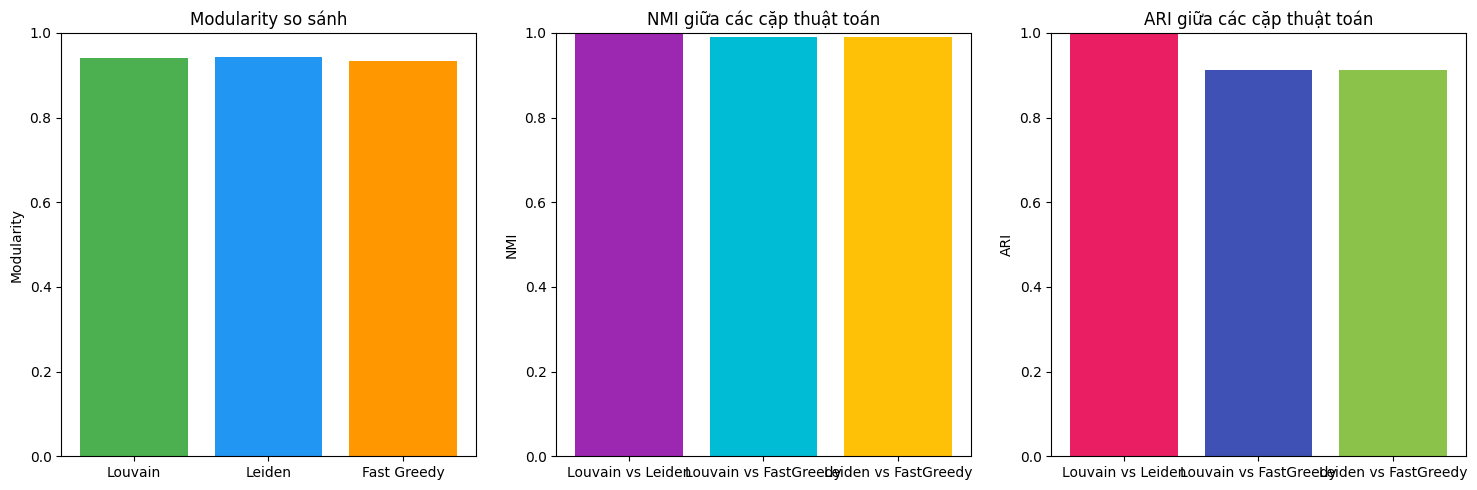

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ==============================
# 1. Dữ liệu từ đoạn code của bạn
# ==============================

# Modularity
mod_scores = {
    "Louvain": mod_louvain,
    "Leiden": mod_leiden,
    "Fast Greedy": mod_fg
}

# NMI giữa các cặp
nmi_scores = {
    "Louvain vs Leiden": nmi_louvain_leiden,
    "Louvain vs FastGreedy": nmi_louvain_fg,
    "Leiden vs FastGreedy": nmi_leiden_fg
}

# ARI giữa các cặp
ari_scores = {
    "Louvain vs Leiden": ari_louvain_leiden,
    "Louvain vs FastGreedy": ari_louvain_fg,
    "Leiden vs FastGreedy": ari_leiden_fg
}

# ==============================
# 2. Vẽ biểu đồ
# ==============================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# --- Biểu đồ Modularity ---
axes[0].bar(mod_scores.keys(), mod_scores.values(), color=['#4CAF50','#2196F3','#FF9800'])
axes[0].set_title("Modularity của các thuật toán")
axes[0].set_ylabel("Modularity")
axes[0].set_ylim(0, 1)

# --- Biểu đồ NMI ---
axes[1].bar(nmi_scores.keys(), nmi_scores.values(), color=['#9C27B0','#00BCD4','#FFC107'])
axes[1].set_title("NMI giữa các cặp thuật toán")
axes[1].set_ylabel("NMI")
axes[1].set_ylim(0, 1)

# --- Biểu đồ ARI ---
axes[2].bar(ari_scores.keys(), ari_scores.values(), color=['#E91E63','#3F51B5','#8BC34A'])
axes[2].set_title("ARI giữa các cặp thuật toán")
axes[2].set_ylabel("ARI")
axes[2].set_ylim(0, 1)

plt.tight_layout()
plt.show()


## Nhận xét

### Modularity 
* Cả Louvain, Leiden, và Fast Greedy đều có giá trị modularity rất cao (~0.93–0.94)
* => cả 3 thuật toán đều tìm được cấu trúc cộng đồng rõ ràng, chất lượng cao
* Không có sự khác biệt lớn giữa các phương pháp => cả 3 thuật toán đều phù hợp cho dữ liệu này
### Normalized Mutual Information (NMI)
* Giá trị NMI giữa các cặp thuật toán đều gần 1
* Nghĩa là các thuật toán Louvain, Leiden, và Fast Greedy đưa ra kết quả phân cụm rất giống nhau
* => Cộng đồng trong mạng này khá rõ ràng, nên phương pháp nào cũng hội tụ về kết quả tương tự
### Adjusted Rand Index (ARI)
* Giá trị ARI, tương tự như MMI cũng rất cao (~0.9–1.0)
* ARI gần 1 cho thấy sự tương đồng cao giữa các phân cụm, loại bỏ ảnh hưởng của sự trùng hợp ngẫu nhiên
* Đặc biệt Louvain vs Leiden có ARI gần 1 => kết quẩ phân cụm các cộng đồng tác giả gần như giống nhau hoàn toàn


# Lưu kết quả 

In [ ]:
import pandas as pd

# ====== 1. NODES FILE ======
nodes = pd.DataFrame({"Id": list(G.nodes())})

# Thêm cộng đồng theo Louvain
nodes["Louvain"] = [louvain_partition[n] for n in nodes["Id"]]

# Leiden
labels_leiden = {}
for i, comm in enumerate(leiden_partition):
    for v in comm:
        labels_leiden[ig_graph.vs[v]["name"]] = i
nodes["Leiden"] = nodes["Id"].map(labels_leiden)

# Fast Greedy
labels_fg = {}
for i, comm in enumerate(fg_partition):
    for v in comm:
        labels_fg[ig_graph.vs[v]["name"]] = i
nodes["FastGreedy"] = nodes["Id"].map(labels_fg)

# Lưu file nodes
nodes.to_csv("nodes_gephi.csv", index=False, encoding="utf-8")

# ====== 2. EDGES FILE ======
# Giữ nguyên dữ liệu edges ban đầu
edges = df.copy()
edges.columns = ["Source", "Target", "Weight"]
edges["Weight"] = edges["Weight"].astype(int)  

# Lưu file edges
edges.to_csv("edges_gephi.csv", index=False, encoding="utf-8")


* import vào Gephi
* Import nodes.csv → chọn "Nodes table"
* Import edges.csv → chọn "Edges table"
* Cài đặt
* Màu sắc theo cộng đồng (Partition).
* Kích thước theo Degree/Weight.
* Chạy layout (ForceAtlas2, Fruchterman-Reingold) để hiển thị đẹp.
